## Modules

In [1]:
using Optim, NLSolversBase, Random, DifferentialEquations, Distributions, Plots
using LinearAlgebra: diag
using DelimitedFiles
using StatsBase
using CSV
using DataFrames
using ImageFiltering
using ProgressBars
using ThreadsX
using NPZ

## Functions

In [2]:
function MCFT(dX,X,Θ,t)
  BG, G, BR, R = X
  s, k, mG, mR = Θ
  dX[1] = s -(mG + k)*BG
  dX[2] = mG*BG - k*G
  dX[3] = s - (mR + k)*BR
  dX[4] = mR*BR - k*R
end

function MCFT_reverse(dX,X,Θ,t)
  BG, G, BR, R = X
  s, k, mG, mR = Θ
  dX[1] = -(s -(mG + k)*BG)
  dX[2] = -(mG*BG - k*G)
  dX[3] = -(s - (mR + k)*BR)
  dX[4] = -(mR*BR - k*R)
end



function f(s, k, BG0, G0, R0, T)
    mG = 6.
    mR = 0.060
    T0 =  BG0+G0
    p = [s, k, mG, mR]
    u0 = [BG0,G0,T0-R0,R0]
    prob = ODEProblem(MCFT,u0,(0.0,T),p)
    sol = solve(prob,Tsit5(),saveat=T)
    odedata = Array(sol)
    return(odedata[2,end], odedata[4,end])
end

function f_BG(s, k, BG0, G0, R0, T)
    mG = 6.
    mR = 0.060
    T0 =  BG0+G0
    p = [s, k, mG, mR]
    u0 = [BG0,G0,T0-R0,R0]
    prob = ODEProblem(MCFT,u0,(0.0,T),p)
    sol = solve(prob,Tsit5(),saveat=T)
    odedata = Array(sol)
    return(odedata[1,end])
end

function f_BG_reverse(s, k, BG0, G0, R0, T)
    mG = 6.
    mR = 0.060
    T0 =  BG0+G0
    p = [s, k, mG, mR]
    u0 = [BG0,G0,T0-R0,R0]
    prob = ODEProblem(MCFT_reverse,u0,(0.0,T),p)
    sol = solve(prob,Euler(),dt=0.005,saveat=T)
    odedata = Array(sol)
    return(odedata[1,end])
end



function f_reverse(s, k, BG0, G0, R0, T)
    mG = 6.
    mR = 0.060
    T0 =  BG0+G0
    p = [s, k, mG, mR]
    u0 = [BG0,G0,T0-R0,R0]
    prob = ODEProblem(MCFT_reverse,u0,(0.0,T),p)
    sol = solve(prob,Euler(),dt=0.005,saveat=T)
    odedata = Array(sol)
    return(odedata[2,end], odedata[4,end])
end

@inbounds @fastmath function evolvePrior(Prior,  G0, R0, T, reverse)
    newPrior = fill(pMin, (gridSize,gridSize,gridSize))
    ThreadsX.foreach(enumerate(sGrid)) do (index_s,s)
        ThreadsX.foreach(enumerate(kGrid)) do (index_k,k)
            ThreadsX.foreach(enumerate(BGGrid)) do (index_BG,BG)
                if reverse
                    BGNew = f_BG_reverse(s, k, BG, G0, R0, T)
                else
                    BGNew = f_BG(s, k, BG, G0, R0, T)
                end
                idx = argmin(abs.(BGGrid .- BGNew))
                newPrior[index_s,index_k,idx] = Prior[index_s,index_k,index_BG]
            end
        end
    end
    return(newPrior)
end



# compute new prior
@inbounds @fastmath function compNewPrior(oldPrior,like, G, R, T; reverse=false)
    # compute posterior distribution
    post = oldPrior .* like
    post ./= sum(post)
    # use posterior as a starting point to create new prior
    newPrior = post
    # evolve the hiden variable
    newPrior = evolvePrior(newPrior, G, R, T, reverse)
    newPrior ./= sum(newPrior)
    # introduce minimal probability
    mask = newPrior .< pMin
    newPrior[mask] .= pMin
    # apply boxcar filter
    ker = ones(2*Rs + 1, 2*Rk+1, 2*RBG+1) ./ ((2*Rs+1)*(2*Rk+1)*(2*RBG+1))
    newPrior = imfilter( newPrior, reflect(centered(ker)), Fill(pMin) )
    newPrior ./= sum(newPrior)
    return(newPrior)
end

    
@inbounds @fastmath function compLike(old_measure,new_measure, sGrid, kGrid, BGGrid, σ, T)
    #use same as in previous code, loop over all combinations
    LL_matrix = Array{Float64}(undef, (gridSize,gridSize,gridSize))
    ThreadsX.foreach(enumerate(sGrid)) do (index_s,s)
        ThreadsX.foreach(enumerate(kGrid)) do (index_k,k)
            ThreadsX.foreach(enumerate(BGGrid)) do (index_BG,BG)
                Ym1, Ym2 = f(s, k, BG, old_measure[1], old_measure[2], T)
                Y1,Y2=new_measure[1], new_measure[2]
                llike = -1/2*log(2π) - 1/2* log(σ^2) - ((Y1 - Ym1).^2 / (2σ^2))  -1/2*log(2π) - 1/2* log(σ^2) - ((Y2 - Ym2).^2 / (2σ^2))
                LL_matrix[index_s,index_k,index_BG]= exp(llike)
            end
        end
    end
    return(LL_matrix)
end



# compute sequence of posterior distributions for a sequence of measured velocities
global σ = 50


@inbounds @fastmath function compPostSequ_optim(uList; T=0.25)
    # initialize array for posterior distributions
    dist = ones(length(uList[1:end,1]),gridSize,gridSize,gridSize)/(gridSize^3) # initialize flat prior
    likelihood = zeros(length(uList[1:end,1]),gridSize,gridSize,gridSize)
    # forward pass (create forward priors for all time steps)
    n=length(uList[1:end,1])
    for i in ProgressBar(2:1:n)
        likelihood[i,1:end,1:end,1:end] = compLike(uList[i-1,1:end], uList[i,1:end],sGrid, kGrid, BGGrid, σ, T) # added
        dist[i,1:end,1:end,1:end] = compNewPrior(dist[i-1, 1:end, 1:end, 1:end], likelihood[i,1:end,1:end,1:end], uList[i,1], uList[i,2], T, reverse=false) # added
    end
    backwardPrior = ones((gridSize,gridSize,gridSize))/(gridSize^3)
    for i in ProgressBar(n:-1:2)
        like = likelihood[i,1:end,1:end,1:end]
        # forward prior * likelihood * backward prior
        dist[i,1:end,1:end,1:end] = dist[i-1,1:end,1:end,1:end] .* like .* backwardPrior
        dist[i,1:end,1:end,1:end] ./= sum(dist[i,1:end,1:end,1:end])
        # generate new backward prior for next iteration
        backwardPrior = compNewPrior(backwardPrior,like, uList[i,1], uList[i,2], T, reverse=true)
    end
    return dist
end

compPostSequ_optim (generic function with 1 method)

## Data import

In [104]:
path_data =  "/Users/bmartin/Documents/PhD/Inference_MCFT/NEW_DATA_mESC/PULSE/"
path_results =  "/Users/bmartin/Documents/PhD/Inference_MCFT/NEW_DATA_mESC/PULSE/"
df = DataFrame(CSV.File(path_data*"results_median_aggregated_smoothed.csv"))

α = 1.

List_green = df.GREEN[5:end]./50
List_red = (df.RED[5:end]./50)*α

println("G/R initial: ",mean(List_green[1:10]./List_red[1:10]) )
println("G/R final: ",mean(List_green[end-5:end]./List_red[end-5:end]) )

uList = ones(length(List_green),2)
for (index,(x,y)) in enumerate(zip(List_green,List_red))
    uList[index, 1:end] .= x,y
end

println("Data parsed!")

G/R initial: 2.3664338117254133
G/R final: 1.8833414027000783
Data parsed!


## Algorithm parameters

In [105]:
# parameter boundaries
gridSize = 60

sBound = [0, 7000]
kBound = [ 0.0,  0.4]
BGBound = [1, 1500]

# algorithm parameters
pMin = 1.0*10^(-8)
Rs   = 9
Rk   = 18
RBG   = 9


# likelihood function
# parameter grid (excluding boundary values)
sGrid  = LinRange(sBound[1], sBound[2], gridSize)
kGrid  = LinRange(kBound[1], kBound[2], gridSize)
BGGrid  = LinRange(BGBound[1], BGBound[2], gridSize)

df_out = DataFrame([kGrid], [:k])
CSV.write(path_results * "kGrid.csv", df_out)

df_out = DataFrame([sGrid], [:s])
CSV.write(path_results * "sGrid.csv", df_out)

df_out = DataFrame([BGGrid], [:BG])
CSV.write(path_results * "BGGrid.csv", df_out)

df_out = DataFrame([[sBound[1]],[sBound[2]],[kBound[1]],[kBound[2]],[BGBound[1]],[BGBound[2]],[pMin], [Rs], [Rk], [RBG]],[:sBound_min,:sBound_max,:kBound_min,:kBound_max,:BGBound_min,:BGBound_max,:pMin, :Rs, :Rk, :RBG])
CSV.write(path_results * "parameters.csv", df_out)

"/Users/bmartin/Documents/PhD/Inference_MCFT/NEW_DATA_mESC/PULSE/parameters.csv"

## Inference and data saving

In [106]:
posteriors = compPostSequ_optim(uList, T=0.25)
npzwrite(path_results * "posteriors.npy",posteriors)
println("Data saved!")

0.0%┣                                               ┫ 0/91 [00:00<00:-5, -0s/it]
1.1%┣▌                                          ┫ 1/91 [00:04<Inf:Inf, InfGs/it]
2.2%┣█                                               ┫ 2/91 [00:08<11:53, 8s/it]
3.3%┣█▋                                              ┫ 3/91 [00:14<09:58, 7s/it]
4.4%┣██                                              ┫ 4/91 [00:17<08:17, 6s/it]
5.5%┣██▋                                             ┫ 5/91 [00:21<07:33, 5s/it]
6.6%┣███▏                                            ┫ 6/91 [00:25<06:59, 5s/it]
7.7%┣███▊                                            ┫ 7/91 [00:28<06:26, 5s/it]
8.8%┣████▏                                           ┫ 8/91 [00:31<06:10, 4s/it]
9.9%┣████▊                                           ┫ 9/91 [00:35<05:59, 4s/it]
11.0%┣█████                                         ┫ 10/91 [00:39<05:47, 4s/it]
12.1%┣█████▋                                        ┫ 11/91 [00:42<05:36, 4s/it]
13.2%┣██████                

Data saved!


▉              ┫ 63/91 [01:19<00:36, 1s/it]
70.3%┣████████████████████████████████▍             ┫ 64/91 [01:20<00:34, 1s/it]
71.4%┣████████████████████████████████▉             ┫ 65/91 [01:21<00:33, 1s/it]
72.5%┣█████████████████████████████████▍            ┫ 66/91 [01:22<00:32, 1s/it]
73.6%┣█████████████████████████████████▉            ┫ 67/91 [01:23<00:30, 1s/it]
74.7%┣██████████████████████████████████▍           ┫ 68/91 [01:24<00:29, 1s/it]
75.8%┣██████████████████████████████████▉           ┫ 69/91 [01:25<00:27, 1s/it]
76.9%┣███████████████████████████████████▍          ┫ 70/91 [01:26<00:26, 1s/it]
78.0%┣████████████████████████████████████          ┫ 71/91 [01:28<00:25, 1s/it]
79.1%┣████████████████████████████████████▍         ┫ 72/91 [01:30<00:24, 1s/it]
80.2%┣█████████████████████████████████████         ┫ 73/91 [01:31<00:23, 1s/it]
81.3%┣█████████████████████████████████████▍        ┫ 74/91 [01:33<00:22, 1s/it]
82.4%┣██████████████████████████████████████        ┫ 75/91 [01:3

## Plot $s$ posterior

434.0445217775384
444.6753518920444
455.64510468287295
479.807309351322
509.62229871274184
551.385789938591
609.616368373174
679.5671406769271
776.362504109408
934.2195877405364
1201.5745975919353
1529.7304059805251
1774.2177447547579
2021.8152220052002
2208.142656087819
2325.1832557523962
2415.9800818021263
2477.4760990861896
2543.358428755639
2594.415826194599
2636.672386822715
2674.0704575537447
2673.726227720508
2668.3842840806783
2680.481064498392
2663.5369511386734
2637.3999151139305
2586.833547985947
2547.0008748479568
2530.046476148487
2490.4789782698845
2447.815433214374
2404.2686252006333
2360.727861830021
2339.679545253492
2329.298900200911
2290.615751487463
2240.234529470179
2176.445565657113
2158.343907288825
2149.237573745879
2122.741442584591
2089.402410795845
2050.883554434584
2003.1278267592613
1934.5027848251436
1842.9221065302838
1780.7664037433376
1717.870470478566
1644.5598400023114
1617.1123512675224
1582.0692721030362
1525.2869487871078
1452.8777399211817
1408.40

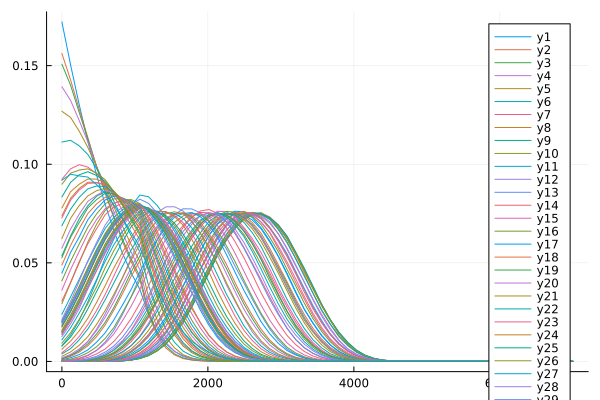

In [107]:
results = posteriors
plot()
table_density = sGrid
List_mean_s = []
for time in 2:1:length(results[1:end,1,1,1])
List_density_s = ones(length(sGrid))
average_s = 0 
for (index_s,s) in enumerate(sGrid)
    sum =0
    for (index_k,k) in enumerate(kGrid)
        for (index_BG,BG) in enumerate(BGGrid)
                X = results[time,index_s,index_k,index_BG]
                if !isnan(X)
                    sum+= X
                    
                end
        end
    end
    List_density_s[index_s]=sum
    average_s += sum*s
end
println(average_s)
push!(List_mean_s, average_s)
plot!(sGrid,List_density_s)
table_density = hcat(table_density,List_density_s)
end
plot!()

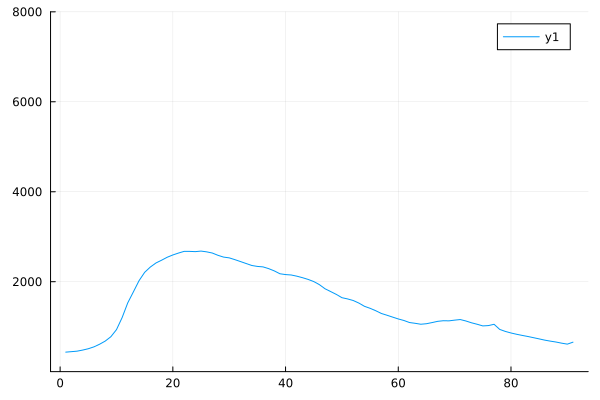

In [108]:
plot(List_mean_s)
ylims!(1, 8000)

## Plot $k$ posterior

0.08032082441860465
0.07555841068659556
0.07158474458707065
0.06795093977120668
0.06460762028768437
0.06167076865715881
0.059256501160662584
0.05727897353548265
0.05602997848397457
0.056037916541168534
0.04529299137054006
0.0589143586939015
0.06610419629735897
0.0725417134335303
0.0751167496435758
0.074046483922792
0.07758269100418175
0.08541059921300774
0.08453890691276195
0.08809524977640218
0.08516451313201648
0.08498643194294192
0.0858111584830434
0.08580600562821172
0.08948865027937199
0.08595381545137373
0.08586375054560846
0.08589776077106209
0.08522831425004423
0.08383814176779986
0.07796620850520629
0.07452646671453136
0.07422738971002965
0.06996835148117735
0.0701581065978683
0.06873901239256225
0.06598504994901427
0.06901496581233336
0.06388027828639531
0.06526685035874569
0.06537810275649299
0.06489989018073991
0.06600073591331336
0.06638986296544837
0.06586841246206385
0.0659830401831378
0.06627372671581433
0.06514696253803057
0.0633989848601423
0.061205483638576
0.0623472

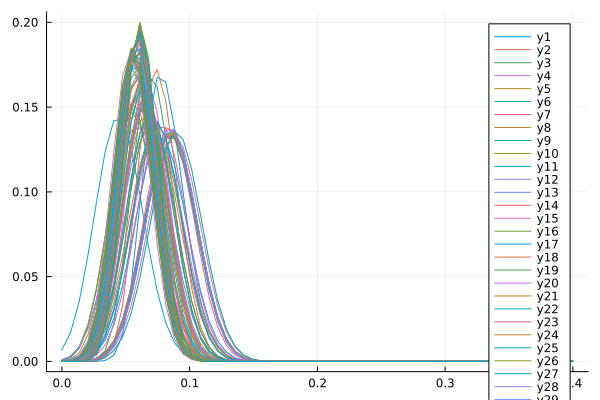

In [109]:
table_density = kGrid
List_mean_k = []
plot()
for time in 2:1:length(results[1:end,1,1,1])
List_density_k = ones(length(sGrid))
average_k = 0
for (index_k,k) in enumerate(kGrid)
    sum =0
    for (index_s,s) in enumerate(sGrid)
        for (index_BG,BG) in enumerate(BGGrid)
                X = results[time,index_s,index_k,index_BG]
                if !isnan(X)
                    sum+= X
                end
        end
    end
    List_density_k[index_k]=sum
    average_k += sum*k
end
println(average_k)
push!(List_mean_k, average_k)
plot!(kGrid,List_density_k)
table_density = hcat(table_density,List_density_k)
end
plot!()

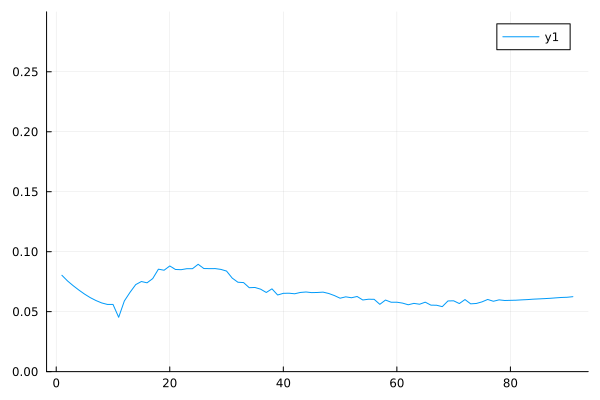

In [110]:
plot(List_mean_k)
ylims!(0.0, 0.3)

## Plot $BG$ posterior

88.36536236795452
86.18938064129442
90.48093745034215
95.76171116292903
102.70043457193934
111.01383107616078
120.71225148904743
131.84012690410188
144.0532782627021
155.75406638185913
177.1336011368437
235.9237744004649
260.63484416703744
304.3508815758555
339.9189221762197
364.099005664073
386.1671956778385
395.83218859259665
403.8459611004436
421.46056826413314
423.96652697484166
434.04146283784564
439.74413888285613
431.24427220167235
444.4926757601188
438.1402826134359
439.4199217066831
431.5530734086129
415.5950435235607
420.7390862431936
414.29851922129785
407.4580332931378
400.91346640370375
388.9905184488348
382.5993401404219
387.10480157846564
382.4161198582836
378.65124492182963
361.0435175618476
355.6938272593064
355.2488270834928
351.0948941067369
350.70007410305567
341.9460277245869
338.2369454517327
334.7904935683062
313.9238220809702
303.5897763036232
291.9771303017527
275.12818881251695
275.0769126259501
269.33793244482996
264.8223368925138
252.00638568520333
243.88823

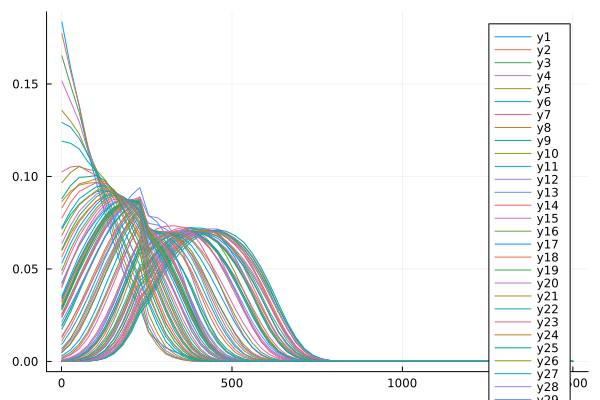

In [111]:
table_density = BGGrid
List_mean_BG = []
plot()
for time in 2:1:length(results[1:end,1,1,1])
List_density_BG = ones(length(BGGrid))
average_BG = 0 
for (index_BG,BG) in enumerate(BGGrid)
    sum =0
    for (index_s,s) in enumerate(sGrid)
        for (index_k,k) in enumerate(kGrid)
                X = results[time,index_s,index_k,index_BG]
                if !isnan(X)
                    sum+= X
                end
        end
    end
    List_density_BG[index_BG]=sum
    average_BG += sum*BG
end
println(average_BG)
push!(List_mean_BG, average_BG)
plot!(BGGrid,List_density_BG)
table_density = hcat(table_density,List_density_BG)
end
plot!()

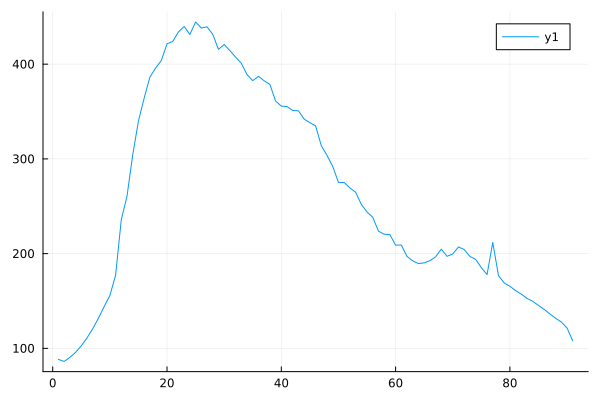

In [112]:
plot(List_mean_BG)

## Data retrodiction

### Functions

In [200]:
function MCFT(dX,X,Θ,t)
  BG, G, BR, R = X
  s, k, mG, mR = Θ
  dX[1] = s -(mG + k)*BG
  dX[2] = mG*BG - k*G
  dX[3] = s - (mR + k)*BR
  dX[4] = mR*BR - k*R
end


function f_retrodiction(s, k, BG0, G0, R0, t0, tf)
    mG = 6.
    mR = 0.06
    T0 =  BG0+G0
    p = [s, k, mG, mR]
    u0 = [BG0,G0,T0-R0,R0]
    prob = ODEProblem(MCFT,u0,(t0, tf),p)
    sol = solve(prob,Euler(),dt =0.001, saveat=0.01)
    odedata = Array(sol)
    return(sol.t[2:end], odedata[1,2:end], odedata[2,2:end], odedata[4,2:end])
end

function serialize(list_s, list_k, BG0, G0, R0, dT; t0=0.0)
    List_green_model = [G0]
    List_BG0_model = [BG0]
    List_red_model = [R0]
    List_time_model = [t0]
    n_points = length(list_s)
    for i ∈ 1:1:n_points
        new_time, new_BG, new_green, new_red = f_retrodiction(list_s[i], list_k[i], List_BG0_model[end], List_green_model[end], List_red_model[end], List_time_model[end], List_time_model[end]+dT)
        List_green_model = vcat(List_green_model, new_green)
        List_red_model = vcat(List_red_model, new_red)
        List_time_model = vcat(List_time_model, new_time)
        List_BG0_model = vcat(List_BG0_model, new_BG)
    end
    return(List_time_model, List_BG0_model,List_green_model, List_red_model)
end
        

serialize (generic function with 1 method)

### Data import

In [251]:
path_data =  "/Users/bmartin/Documents/PhD/Inference_MCFT/NEW_DATA_3T3_mono2/PULSE/"
path_results =  "/Users/bmartin/Documents/PhD/Inference_MCFT/NEW_DATA_3T3_mono2/PULSE/"



list_k = DataFrame(CSV.File(path_results * "average_k.csv"))[:,1]
list_s = DataFrame(CSV.File(path_results * "average_s.csv"))[:,1]
list_BG = DataFrame(CSV.File(path_results * "average_BG.csv"))[:,1]


df = DataFrame(CSV.File(path_data*"results_median_aggregated_smoothed.csv"))

#α = 1.0425
#α = 0.45
α : 0.8

y1 = df.GREEN./250
y2 = (df.RED./250)*α
x = df.time_hours

println("Data imported!")

Data imported!


### ODE serial integration

In [252]:
BG0 = list_BG[5]
G0 = y1[5]
R0 = y2[5]

dT = 0.25

List_time_model, List_BG0_model, List_green_model, List_red_model = serialize(list_s, list_k, BG0, G0, R0, dT)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  21.91, 21.92, 21.93, 21.94, 21.95, 21.96, 21.97, 21.98, 21.99, 22.0], [161.48994606652812, 162.067856656202, 162.61125395365949, 163.12219912088796, 163.60263022559846, 164.0543695925159, 164.47913071564497, 164.87852475772956, 165.25406666155905, 165.6071808963028  …  131.60319000283724, 131.7878308107902, 131.96154436200501, 132.12497734418397, 132.27873817330234, 132.42339925857397, 132.5594991333726, 132.6875444600439, 132.80801191606906, 132.92134996860452], [20055.23170746445, 20037.08675821617, 20019.000711794393, 20000.97147317545, 19982.997070476962, 19965.075647606496, 19947.205457349206, 19929.384854868335, 19911.612291593825, 19893.886309475925  …  11889.475695386527, 11887.640443320943, 11885.817469820366, 11884.006127090815, 11882.20580561095, 11880.415931867085, 11878.635966222282, 11876.865400911538, 11875.103758155614, 11873.350588386504], [6673.6256441144305, 6672.47653498265, 6671.319185446824, 6670.1536

### Green trajectory

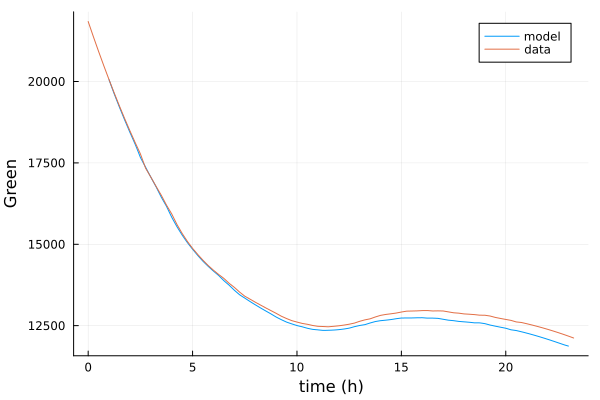

In [253]:
plot(List_time_model.+1., List_green_model, label="model")

plot!(x, y1, label="data")
ylabel!("Green")
xlabel!("time (h)")

### Red trajectory

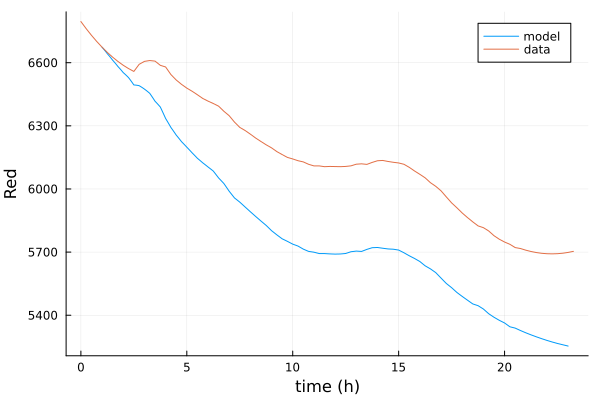

In [254]:
plot(List_time_model.+1., List_red_model, label="model")

plot!(x, y2, label="data")
ylabel!("Red")
xlabel!("time (h)")

### BG trajectory

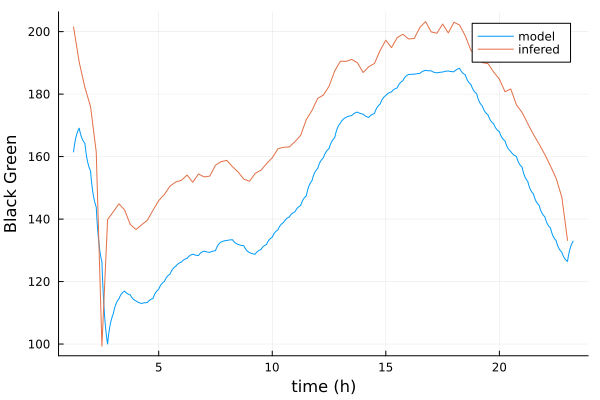

In [255]:
plot(List_time_model.+1.25, List_BG0_model, label="model")

plot!(x[6:end-1], list_BG, label="infered")
ylabel!("Black Green")
xlabel!("time (h)")

In [842]:
df_out = DataFrame([List_time_model.+1.,List_green_model, List_red_model], [:t,:Gmodel, :Rmodel])

CSV.write(path_data*"data_ODE.csv", df_out)

"/Users/bmartin/Documents/PhD/Inference_MCFT/CHX_MYCi_definitive_22_7_22_smoothed_raw/MYCi_release_definitive_22_7_22/data_ODE.csv"